# Stock Market Predictions with LSTM in Python

In this project I'm planing to do a tool to predict the stock market with Long-Short-Term Memory (LSTM)

In [9]:
!pip install setuptools yfinance matplotlib pandas scikit-learn tensorflow

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 14.8 MB/s eta 0:00:01
   ---------------------------------------  8.1/8.1 MB 20.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 18.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------- ----------- 5.8/8.0 MB 29.1 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 25.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
    --------------------------------------- 6.0/332.0 MB 28.9 MB/s eta 0:00:12
   - -------------------------------------- 12.1/332.0 MB 29.0 MB/s eta 0:00:12
   -- ------------------------------------- 17.8/332.0 MB 29.0 MB/s eta 0:00:11
   -- ------------------------------------- 23.6/332.0 MB 28.9 MB/s eta 0:00:11
   --- ------------------------------------ 28.8/332.0 MB 27.7 MB/s eta 0:00:11
   --- 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# all imports
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

### Getting the data

To get the data you either have to download it on Kaggle (https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), generate a API key on Alpha Vantage (https://www.alphavantage.co/) or use yfinance.

Here I'm using the data from Kaggle


In [26]:
# Getting my data from Kaggle

#data_source = 'kaggle'
#data_source = 'alphavantage'
data_source = 'yfinance'

# Amarican Airlines stock market prices
ticker = "NVDA"

if data_source == 'alphavantage':
        print("Load data via Alpha Vantage API...")
        api_key = '' # use your api key here

        # JSON file with all the stock market data for AAL from the last 20 years
        url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

        # save data to this file
        file_to_save = 'stock_market_data-%s.csv'%ticker

        if not os.path.exists(file_to_save):
                try:
                        with urllib.request.urlopen(url_string) as url:
                                data = json.loads(url.read().decode())
                                # extract the data
                                if 'Time Series (Daily)' in data:
                                        data = data['Time Series (Daily)']
                                        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
                                        # parse JSON (it may take some time)
                                        for k, v in data.items():
                                                date = dt.datetime.strptime(k, '%Y-%m-%d')
                                                data_row = [date.date(), float(v['3. low']), float(v['2. high']),
                                                                float(v['4. close']), float(v['1. open'])]
                                                df.loc[len(df)] = data_row
                                        
                                        print(f'Data stored under: {file_to_save}')
                                        df.to_csv(file_to_save, index = False)
                                else:
                                        print('Error: No data received. Checking API key or limit.')
                                        df = pd.DataFrame() # Empty DF as a fallback
                except Exception as e:
                        print(f'Download error: {e}')
                        df = pd.DataFrame()
        else:
                print('File already exists. Loading from CSV...')
                df = pd.read_csv(file_to_save)
elif data_source == 'kaggle':
        print('Loading data from local Kaggle file...')
        # Make sure the 'Stocks' folder and the file exist.
        file_path = os.path.join('Stocks', 'hpq.us.txt')

        if os.path.exists(file_path):
                df = pd.read_csv(file_path, delimiter=',', usecols=['Date','Open','High','Low','Close'])
                print('Data loaded from Kaggle.')
        else:
                print(f'Error: File not found at: {os.path.abspath(file_path)}')
                print('Check if the folder "Stocks" is in the same directory as your notebook.')
                df = pd.DataFrame()
else:
        print(f"Load data for {ticker} via yfinance...")
        df = yf.download(ticker, period="max")
        df = df.reset_index() # Make index column
        df = df[['Date', 'Open', 'High', 'Low', 'Close']] # Enforce the same structure

# Cleanup
# No matter where the data comes from, we process it immediately.
if not df.empty:
        # Ensure that 'Date' is a real date
        df['Date'] = pd.to_datetime(df['Date'])
        # Sort by date
        df = df.sort_values('Date')
        # Reset index
        df = df.reset_index(drop=True)

        print("Data successfully loaded!")
        print(df.head())
else:
        print("ATTENTION: DataFrame is empty. Please check the data source!")

Load data for NVDA via yfinance...


[*********************100%***********************]  1 of 1 completed

Data successfully loaded!
Price        Date      Open      High       Low     Close
Ticker                 NVDA      NVDA      NVDA      NVDA
0      1999-01-22  0.040111  0.044767  0.035575  0.037605
1      1999-01-25  0.040589  0.042021  0.037605  0.041545
2      1999-01-26  0.042021  0.042857  0.037724  0.038321
3      1999-01-27  0.038440  0.039395  0.036291  0.038202
4      1999-01-28  0.038202  0.038440  0.037843  0.038082


### Visualization of the data

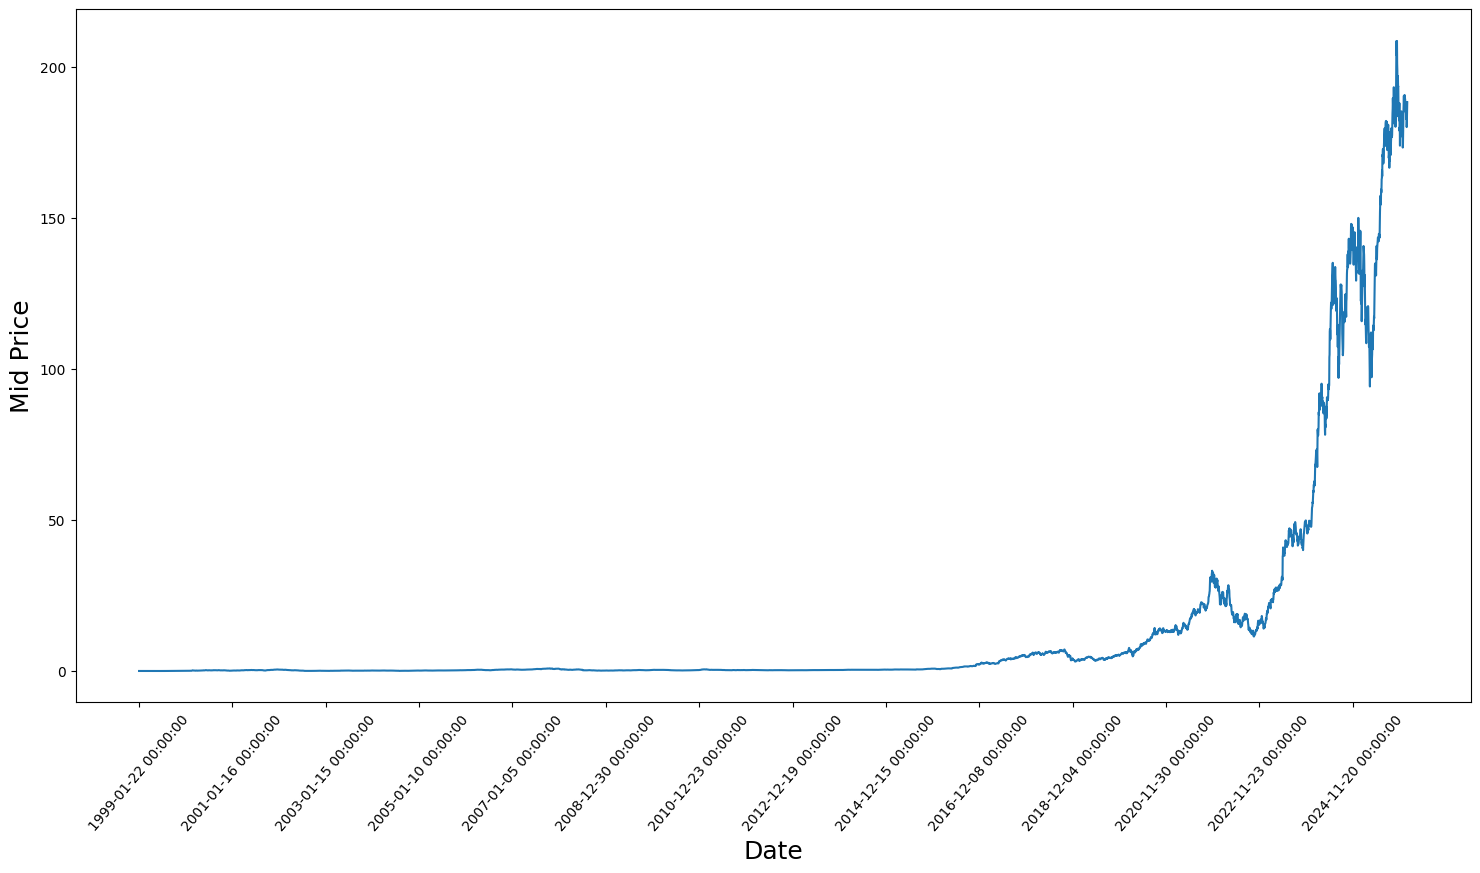

In [34]:
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=50)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()


### Splitting Data into a trainig set and a test set

Mid-price can be calculated by using the average of the highest and lowest recorded prices an a day

In [ ]:
high_price = df.loc[:,'High'].as_matrix()
low_price = df.loc[:, 'Low'].as_matrix()
mid_price = (high_price + low_price)/2.0

Splitting the data into test and training data.

The first 11.000 data point will be used for training and the rest will be used for the tests

In [ ]:
train_data = mid_price[:11000]
test_data = mid_price[11000:]

### Normalizing the data

To normalize the data I'm using a scalar. And to do so, I'm using MinMaxScalar which scales all the data to be in the region of 0 and 1.

In [ ]:
scalar = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)